# Learning Rate

Die Learning Rate (LR) legt fest, wie stark die Gewichte der Neuronen pro Trainingslauf angepasst werden, und beeinflusst somit direkt die Trainingsgeschwindigkeit des Netzwerkes. Die LR ist ein wichtiger Hyperparameter: Ist sie zu niedrig, kovergiert das Model nur sehr langsam. Ist sie zu hoch, kann die Fehlerfunktion unter Umständen überhaupt nicht minimiert werden. In diesem Notebook werden diese Fälle demonstriert, sowie der LR Finder ausprobiert.

Zuerst wieder das Datenset vorbereiten:

['Ahorn', 'Birke', 'Eiche', 'Kastanie']


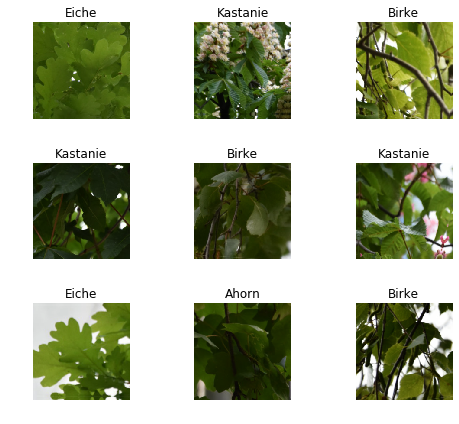

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

path = Path('datasets/leaves')

np.random.seed(1337)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=10,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6))
print(data.classes)

## LR gut

Der Default-Wert für die LR ist hier 0.003

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, 0.003)

epoch,train_loss,valid_loss,error_rate,time
0,0.915237,0.292150,0.122905,00:04
1,0.542470,0.162450,0.061452,00:04
2,0.403551,0.120086,0.044693,00:04
3,0.286805,0.118759,0.050279,00:04


## LR zu niedrig

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, 0.00001)

epoch,train_loss,valid_loss,error_rate,time
0,1.706942,1.473615,0.670391,00:04
1,1.728150,1.419150,0.642458,00:04
2,1.671096,1.423881,0.636872,00:04
3,1.597217,1.398891,0.597765,00:04


Auch nach vier Epochen ist das Training hier noch nicht so weit wie nach einer Epoche mit LR = 0.003

## LR zu hoch

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, 0.9)

epoch,train_loss,valid_loss,error_rate,time
0,78.665756,1729292.000000,0.849162,00:04
1,394.940155,234.721130,0.681564,00:04
2,206.062958,73.522049,0.653631,00:04
3,83.582596,8569.510742,0.553073,00:04


Konvergiert ebenfalls nicht gut, Error Rate wird stellenweise sogar höher.

## Models speichern und laden

Models zu speichern und zu laden ist in der Trainingsphase insofern wichtig, um nicht das komplette Training neu starten zu müssen, falls ein Schritt fehlschlägt oder das Model verschlechter. Für das Speichern kann folgender Befehl verwendet werden (per default wird im jeweiligen Datenset-Ordner ein "models" Verzeichnis angelegt):

In [10]:
learn.save("trained_model", return_path=True)

PosixPath('datasets/leaves/models/trained_model.pth')

Laden von Models mit:

In [11]:
learn = learn.load("trained_model")

## Learning Rate Finder

Mit dem Learning Rate Finder können geeignete Werte für die LR gefunden werden. Als Daumenregel ist eine geeignete maximale LR bei dem Wert, bei dem die Kurve für den Loss anfängt stark abzufallen:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


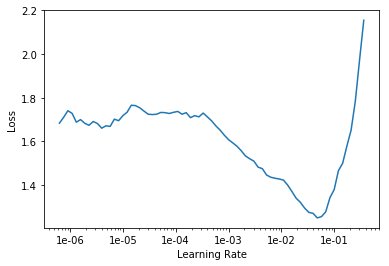

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

Hier sieht man, das Werte ab 0,001 gut für die maximale LR geeignet sind. (Achtung: x-Achse ist logarithmisch.)

## Feintuning

Da wir ein vortrainiertes Netz und Transfer Learning nutzen, haben wir bisher nur die hinteren Layers des Netzes neu trainiert. Es ist aber möglich, nach einem anfänglichen Training noch ein Finetuning für das gesamte Netz vorzunehmen.
Hierbei werden mit unfreeze() die vorderen Layers ebenfalls für das Training "freigegeben". Beim Finetuning mit kleinen Datensätzen ist aber darauf zu achten, dass nicht zu viel trainiert werden darf, da das Model sonst anfällig für Overfitting ist.

In [17]:
learn_unfreeze = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate)
learn_unfreeze.fit_one_cycle(4)

learn_unfreeze.unfreeze()
learn_unfreeze.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.938761,0.413302,0.150838,00:04
1,0.599436,0.245317,0.072626,00:04
2,0.435433,0.230838,0.067039,00:04
3,0.378666,0.235976,0.078212,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.628250,0.779688,0.206704,00:06
1,0.470662,0.175091,0.055866,00:06


In [ ]:
Beim Feintuning ist ein interessante Beobachtung, dass das Netz erst schlechter wird, um dann Final aber bessere Ergebnisse zu liefern. Dies ist ein Seiteneffekt der Cyclical Learning Rates.